2025.06.12

1. 초기값이 그대로일 때, 증가폭이 변하지 않는가?
2. 초기값이 그대로일 때, $\beta$ 에 따라 증가폭이 변하는가?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yaml
from pathlib import Path
from src.L_functions import get_vol, get_neg_sharpe, rast
from src.Models import Multi_CBO_model, gen_Psi
from src.utils import Lmin, avg_x, avg_L, load_config, next_run_index, save_run_config
import random
import os
import sys
from tqdm import trange  # pip install tqdm

\begin{align*}
aL_1+(1-a)L_2 &= a\left(x_1^2+\frac{1}{4}x_2^2\right)+(1-a)\left(\frac{1}{4}(x_1-2)^2+(x_2-2)^2\right)\\
&= \frac{1+3a}{4}x_1^2-(1-a)x_1+1-a+\frac{4-3a}{4}x_2^2-4(1-a)x_2+4(1-a)
\end{align*}
Therefore, 
\begin{equation*}
X^*_a = \left(\frac{2(1-a)}{1+3a}, \frac{8(1-a)}{4-3a}\right)
\end{equation*}

In [2]:
RESULTS_ROOT = Path("./results")
SIMNAME_SUB  = "250612Exp"


# ---- 메인 ----
np.random.seed(1)
base_cfg   = load_config("configs/config2.yaml")

for beta in [16]:
    run_idx  = next_run_index(RESULTS_ROOT, SIMNAME_SUB)
    run_name = f"{SIMNAME_SUB}_{run_idx}"
    run_root = RESULTS_ROOT / run_name           # 상위 simname 폴더 (여기 아래에 sim0000 ... 생성)
    run_root.mkdir(parents=True, exist_ok=True)

    # 원본 yaml 직접 덮지 말고 메모리에서 수정
    config = dict(base_cfg)
    config["beta"]    = beta
    config["simname"] = run_name
    save_run_config(run_root, config)

    # 문제 정의
    L1 = lambda x: x[0]**2 + x[1]**2/4
    L2 = lambda x: (x[0]-2)**2/4 + (x[1]-2)**2
    # 문제 정의
    L1 = lambda x: 5*(x[0]-0.1)**2 + (x[1]-0.1)**2
    L2 = lambda x: (x[0]-0.9)**2 + 5*(x[1]-0.9)**2

    # alpha / minimizer 준비 (재현 위해 고정 seed 사용 중)
    a = np.random.uniform(size=config['nump'])
    minimizer = np.zeros((config['nump'], 2))
    denom1 = 10*(1 + 4*a)
    denom2 = 2*(5 - 4*a)
    minimizer[:, 0] = 1*(9 - 4*a) / denom1
    minimizer[:, 1] = 1*(9 - 8.8*a) / denom2
    
#     denom1 = (1 + 3*a)
#     denom2 = (4 - 3*a)
#     minimizer[:, 0] = 2*(1 - a) / denom1
#     minimizer[:, 1] = 8*(1 - a) / denom2
    
    a_col = a.reshape(-1, 1)

    # 공용 초기값 (원하면 실험별 동일 초기값)
    x0 = np.random.rand(config['nump'], config['D'])
    np.save(run_root / "x0.npy", x0)
    np.save(run_root / "alpha.npy", a)

    nsim    = int(config['sim'])
    maxiter = int(config.get('maxiter', 1000))

    # 진행률: 바깥 루프(시뮬레이션 개수)
    for simnum in range(nsim):
        # 개별 sim 폴더 생성 ...
        sim_dir  = run_root / f"sim{simnum:04d}"
        figs_dir = sim_dir / "figs"
        figs_dir.mkdir(parents=True, exist_ok=True)
    
        model = Multi_CBO_model(L1, L2, config)
        model.path = str(sim_dir.resolve()) + "/"
        model.make_path()
    
        x = np.load(run_root / "x0.npy")
        E = np.zeros(maxiter, dtype=float)
        model.trace_func(x, lambda z: z, "coord")    
        for it in range(maxiter):
            diff = x - minimizer
            E[it] = np.einsum("ij,ij->i", diff, diff).mean()
    
            if config.get('model', 1) == 1:
                x = model.step(x, a_col, L1, L2)
            else:
                raise NotImplementedError("model!=1 분기 사용 시 다른 모델 지정 필요")
    
            model.trace_func(x, lambda z: z, "coord")
            # --- 진행률 (print 버전) ---
            if (it + 1) % 50 == 0 or it == maxiter - 1:
                pct = (simnum * maxiter + it + 1) / (nsim * maxiter) * 100
                print(f"\rProgress: {pct:.1f}%", end="")
    
        # 시뮬레이션 종료 후 개행
        print(" done.")
    
        model.save_func("coord", simnum=simnum)
    
        # eps = 1e-12
        # plt.figure()
        # plt.plot(np.arange(maxiter), E + eps, label='E_n')
        # plt.yscale('log')
        # plt.title(f'sim{simnum:04d}')
        # plt.xlabel('iter')
        # plt.ylabel('energy')
        # plt.legend()
        # plt.savefig(figs_dir / "energy.png", dpi=150, bbox_inches="tight")
        # plt.close()


Progress: 100.0% done.


In [6]:
# plot.ipynb (셀 1)
from pathlib import Path
import numpy as np
from src.plot import load_coord, find_first_coord, plot_particles_at_iters

sim_dir = Path("results/250612Exp_2/sim0000")   # <- 본인 경로로 변경
coord_pkl = find_first_coord(sim_dir, pattern="coord_*.pkl")
coord = load_coord(coord_pkl)                   # (T,N,D)

# 필요시 minimizer 불러오기 (run에서 저장했다면)
minimizer_path = sim_dir.parent / "minimizer.npy"  # 예: 상위 simname 폴더에 저장해 두었다면
minimizer = None
if minimizer_path.exists():
    minimizer = np.load(minimizer_path)

iters = [0,1,2,3,4,5,6,7,8,9, 10,11,12,13,14,15,16,17,18,19, 20, 50, 100]
plot_particles_at_iters(coord, iters, sim_dir / "frames", title_prefix=sim_dir.name,
                        minimizer=minimizer, xlimylim=(0, 2, 0, 2))


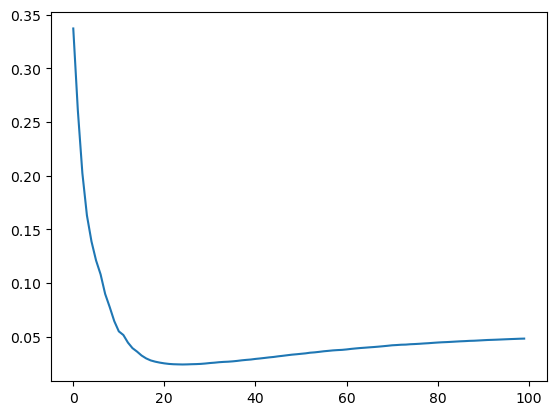

In [4]:
import matplotlib.pyplot as plt
plt.plot(E)